# Initial Coding Attempts for Master Thesis

>This notebook reproduces a paper named 'The Old and the New: Can Physics-Informed Deep-Learning Replace Traditional Linear Solvers?' by Stefano Markidis.

The goal lies in solving a partial differential equation (PDE) using a neural network. We are interested in the Poisson Eq. ($\nabla^2 u(x) = f(x)$)

We use a fully connected neural network that takes two coordinates as input (2d-input) and returns a single scalar value (1d-output).
The network is supposed to approximate a solution to the PDE and hence the outputs should minimize the residual of the PDE.
Our physical information is encoded in the loss fct. (PDE is rewritten to equate 0 on r.h.s; e.g. $\nabla^2u - f(x) = 0$)


In [1]:
import torch 
import matplotlib.pyplot as plt
import numpy as np

from utilities import *

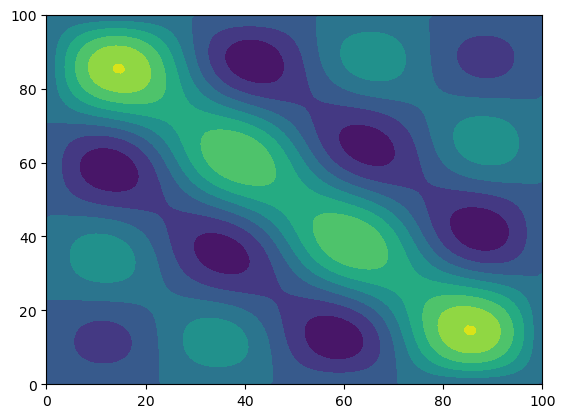

In [7]:
## plot the source term for visualisation

source_test = torch.tensor([[(i/100,j/100) for i in range(101)] for j in range(101)])
plt.contourf(source(source_test));

In [9]:
## init the model, optimizer and loss archives

model = PINN()
init_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
fine_optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-5)

us = {'loss': [],
      'u_xx': [],
      'u_yy': [],
      'grad_norm': []}

model

PINN(
  (approximator): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=1, bias=False)
  )
)

#### gradient experiments

test how gradients are computed especially w.r.t. torch's autogradient lib, and their hessian function. 
it turns out, all gradients are calculated as expected. 

--- closed ---

In [82]:
x = torch.ones((2,), requires_grad=True) * 4
y = model(x)

grad = torch.autograd.grad(y, x, retain_graph=True)[0].view(1,-1)
para1, para2, para3, para4 = model.approximator.parameters()
manual_grad = para4 @ (para3 @ (para2 @ (para1)))
# hessian = torch.autograd.functional.hessian(model, x)
# x, y, grad, manual_grad.shape
grad, manual_grad, torch.isclose(grad, manual_grad)

(tensor([[-0.0087, -0.0017]]),
 tensor([[-0.0947, -0.0003]], grad_fn=<MmBackward0>),
 tensor([[False, False]]))

In [45]:
# data
x = torch.randn((1,2), requires_grad=True)

# dummy layer
wei1 = torch.randn((2,2), requires_grad=True)
wei2 = torch.randn((2,1), requires_grad=True)


def layer(x):
    x = x @ wei1
    x = torch.nn.functional.tanh(x)
    x = x @ wei2
    return x

hessian = torch.autograd.functional.hessian(layer, x)
grads = torch.autograd.grad(layer(x), x, create_graph=True)[0]
# second_grad = torch.autograd.grad(grads, x, grad_outputs=torch.ones(2,))
dtanh = torch.diag((1-torch.tanh(x @ wei1)**2).flatten())
man_grads = ((wei1 @ dtanh) @ wei2).T


# print(f'{x.shape=}')
# print(f'{wei1.shape=}')
# print(f'{wei2.shape=}')
# print(f'{dtanh.shape=}')
# print(f'{man_grads.shape=}')

print(x, x.shape, sep=',\t\t')
print(layer(x), layer(x).shape, sep=',\t\t')
# print(hessian, hessian.shape, sep=',\t\t')
print(grads, grads.shape, sep=',\t\t')
print(man_grads, man_grads.shape, sep='\t\t')
torch.isclose(grads, man_grads)

tensor([[-0.3236, -0.0145]], requires_grad=True),		torch.Size([1, 2])
tensor([[-0.0099]], grad_fn=<MmBackward0>),		torch.Size([1, 1])
tensor([[0.0215, 0.1980]], grad_fn=<MmBackward0>),		torch.Size([1, 2])
tensor([[0.0215, 0.1980]], grad_fn=<PermuteBackward0>)		torch.Size([1, 2])


tensor([[True, True]])

###

In [5]:
## TRAINING LOOP

batches = 100
batch_size = 30
lossi = []

optimizer = fine_optimizer
count = 0

closure = get_closure(optimizer, batch_size, model, us, lossi, count)

for _ in range(batches):

    if optimizer == init_optimizer:
        closure()
        optimizer.step()
    elif optimizer == fine_optimizer:
        optimizer.step(closure)

    # with torch.no_grad():
    us['grad_norm'] += [np.mean([p.grad.norm() for p in model.parameters()])] * batch_size

# loss writing
us['loss'] += lossi


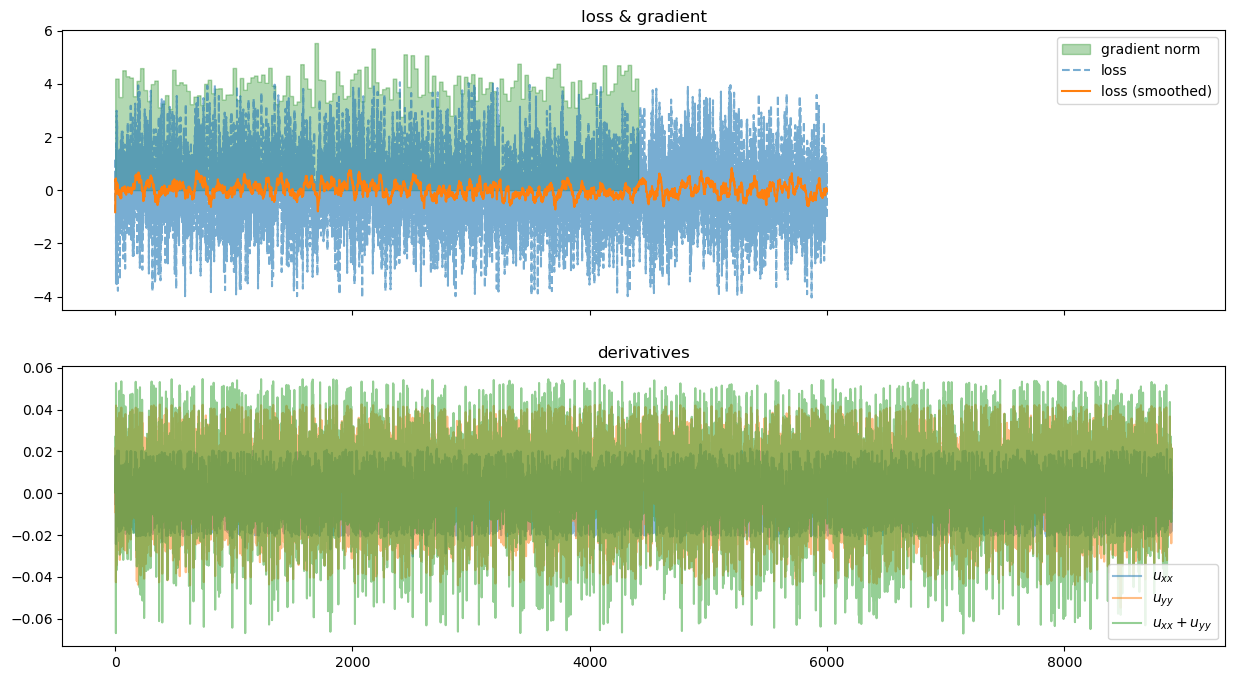

In [6]:
# plotting loss & other quantities
fig,ax = plt.subplots(2,1,figsize=(15,8),sharex=True)
ax[0].fill_between(range((len(us['grad_norm']))), us['grad_norm'], alpha=0.3, color='green', label='gradient norm')
ax[0].plot(us['loss'], label='loss', linestyle='--', alpha=0.6)
ax[0].plot([np.mean(us['loss'][max(0,i-batch_size):i]) for i in range(1,len(us['loss']))], label='loss (smoothed)')
ax[0].legend()
ax[0].set_title('loss & gradient')
# ax[0].set_ylim([0, 100])
ax[1].plot(us['u_xx'],alpha=0.5,label='$u_{xx}$')
ax[1].plot(us['u_yy'],alpha=0.5,label='$u_{yy}$')
ax[1].plot([i+j for i,j in zip(us['u_xx'], us['u_yy'])],alpha=0.5,label='$u_{xx} + u_{yy}$')
ax[1].set_title('derivatives')
ax[1].legend()
# ax[1].set_ylim([0, 100])
plt.show()

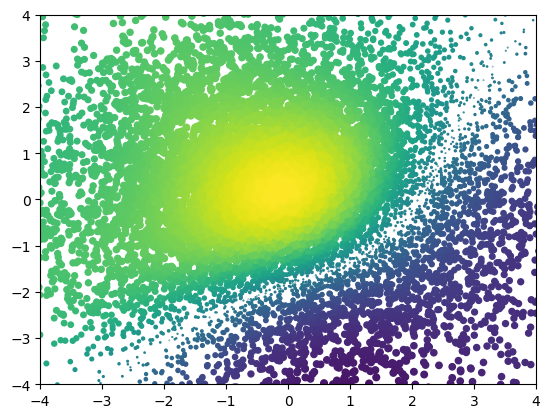

In [228]:
model.eval()

with torch.no_grad():
    xval = torch.randn((10001,2)) * 2
    res = model(xval)

    plt.scatter(xval[:,0], xval[:,1], s=3*torch.log(10**torch.abs(res)), c=res)
    plt.xlim([-4,4])
    plt.ylim([-4,4])

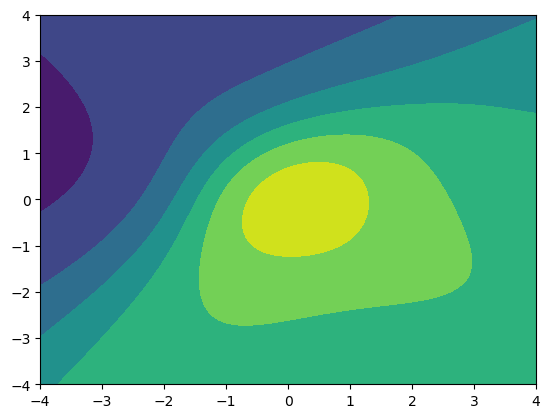

In [230]:
model.eval()

with torch.no_grad():
    xval = np.linspace(-4,4,101)
    xs, ys = np.meshgrid(xval, xval)
    res = np.zeros_like(xs)
    for i in range(xs.shape[0]):
        for j in range(xs.shape[1]):
            res[i,j] = model(torch.tensor([xval[i], xval[j]], dtype=torch.float))

plt.contourf(xs,ys,res);